In [1]:
%%capture
## Install and import anything required. Capture hides the output from the cell.
# @title Install and import required packages. (Run Cell)

%env XLA_PYTHON_CLIENT_MEM_FRACTION=0.8

!pip install dm-haiku
!pip install optax
!pip install distrax
!pip install einops
!pip install livelossplot


In [4]:
import os

# Check if the environment variable is set and not an empty string before converting it to an integer
if "COLAB_GPU" in os.environ and os.environ["COLAB_GPU"].isdigit():
    if int(os.environ["COLAB_GPU"]) > 0:
        print("A GPU is connected.")
elif "COLAB_TPU_ADDR" in os.environ and os.environ["COLAB_TPU_ADDR"]:
    print("A TPU is connected.")
else:
    print("No GPU or TPU found.")


A TPU is connected.


In [9]:
# !pip install --upgrade jax jaxlib
!pip uninstall jax jaxlib -y
!pip install jax jaxlib

Found existing installation: jax 0.4.19
Uninstalling jax-0.4.19:
  Successfully uninstalled jax-0.4.19
Found existing installation: jaxlib 0.4.19
Uninstalling jaxlib-0.4.19:
  Successfully uninstalled jaxlib-0.4.19
  Using cached jax-0.4.19-py3-none-any.whl (1.7 MB)
  Using cached jaxlib-0.4.19-cp310-cp310-manylinux2014_x86_64.whl (85.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.26.1 which is incompatible.


In [1]:
# import os

# # https://stackoverflow.com/questions/68340858/in-google-colab-is-there-a-programing-way-to-check-which-runtime-like-gpu-or-tpu
# if int(os.environ["COLAB_GPU"]) > 0:
#     print("a GPU is connected.")
# elif "COLAB_TPU_ADDR" in os.environ and os.environ["COLAB_TPU_ADDR"]:
#     print("A TPU is connected.")
#     import jax.tools.colab_tpu

#     jax.tools.colab_tpu.setup_tpu()
# else:
#     print("Only CPU accelerator is connected.")

from functools import partial
import requests

import jax
import jax.numpy as jnp
from jax import grad, jit, vmap
import haiku as hk
import optax
import distrax
import tensorflow as tf
import tensorflow_datasets as tfds
from einops import rearrange
from opt_einsum import contract
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import numpy as np
from tqdm.auto import tqdm
from PIL import Image
from livelossplot import PlotLosses

matplotlib.rc("image", cmap="gray_r")

In [2]:
# @title Helper Functions. (Run Cell)


def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a[..., t]
    return jnp.reshape(out, (batch_size, *((1,) * (len(x_shape) - 1))))


def plot_log_gaussian_ellipse(
    ax,
    mean,
    cov,
    color="b",
    alpha=1,
    lw=1,
    label=None,
    MAP_size=5,
    std_levels=[1, 2, 4, 6],
):

    eigenvalues, eigenvectors = jnp.linalg.eigh(cov)
    theta = np.linspace(0, 2 * np.pi, 1200)
    std_ellipsis = (np.sqrt(eigenvalues[None, :]) * eigenvectors) @ jnp.stack(
        [np.sin(theta), np.cos(theta)]
    )

    artists = []

    for level in std_levels:
        artists.append(
            ax.plot(
                mean[0] + level * std_ellipsis[0, :],
                mean[1] + level * std_ellipsis[1, :],
                c=color,
                alpha=alpha,
                lw=lw,
            )
        )

    artists.append(
        ax.scatter(
            [mean[0]],
            [mean[1]],
            MAP_size,
            color=color,
            label=label,
            alpha=alpha,
            marker="x",
        )
    )

    return artists

In [3]:
# @title Check what device you are using (Run Cell)
print(f"Num devices: {jax.device_count()}")
print(f" Devices: {jax.devices()}")

Num devices: 1
 Devices: [CpuDevice(id=0)]


**Deep Generative Models**

[Optional] Quick Probability Refresher – The Sum, Product, and Bayes' rules

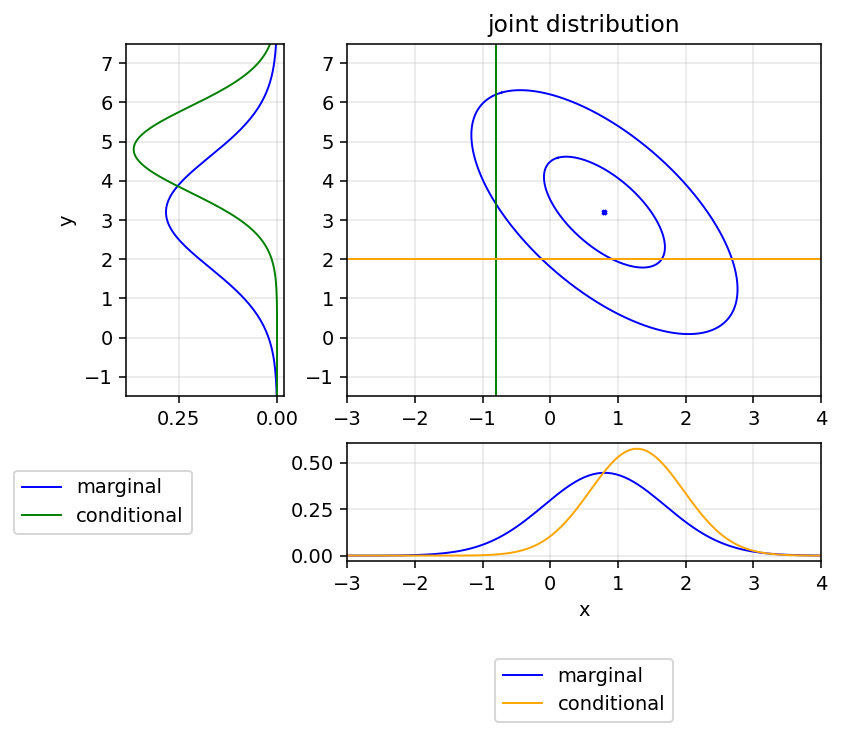

In [6]:
#  Let's plot its marginals and conditionals! (Run Cell)

#  The marginals over x and y are obtained by taking the joint and projecting it onto the x and y axis, respectively.

#  The conditionals are obtained by choosing a line, such as x=-0.8 and projecting the other variable, i.e. y, onto that line.

from matplotlib import gridspec
from scipy.stats import norm

mean = np.array([0.8, 3.2])
covariance = np.array([[0.8, -0.8], [-0.8, 2.0]])

x_condition = -0.8
y_condition = 2


def Gaussian_conditional(mean, cov, x=None, y=None):
    assert not (x is None and y is None) and not (x is not None and y is not None)
    if x is not None:
        var = cov[1, 1] - cov[1, 0] * cov[0, 0] ** (-1) * cov[0, 1]
        mu = mean[1] + cov[1, 0] * cov[0, 0] ** (-1) * (x - mean[0])
    else:
        var = cov[0, 0] - cov[0, 1] * cov[1, 1] ** (-1) * cov[1, 0]
        mu = mean[0] + cov[0, 1] * cov[1, 1] ** (-1) * (y - mean[1])
    return mu, var


c_mu_y, c_var_y = Gaussian_conditional(mean, covariance, x=x_condition, y=None)
c_mu_x, c_var_x = Gaussian_conditional(mean, covariance, x=None, y=y_condition)

xrange = np.linspace(-10, 10, 300)
density_x = norm.pdf(xrange, 0.8, 0.8**0.5)
density_y = norm.pdf(xrange, 3.2, 2.0**0.5)

cond_density_y = norm.pdf(xrange, c_mu_y, c_var_y**0.5)
cond_density_x = norm.pdf(xrange, c_mu_x, c_var_x**0.5)


plt.figure(dpi=140)
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 3], height_ratios=[3, 1])
ax = plt.subplot(gs[0, 1])
axl = plt.subplot(gs[0, 0], sharey=ax)
axb = plt.subplot(gs[1, 1], sharex=ax)

plot_log_gaussian_ellipse(
    ax,
    mean,
    covariance,
    color="b",
    alpha=1,
    lw=1,
    label=None,
    MAP_size=5,
    std_levels=[1, 2.2],
)
ax.set_title("joint distribution")
ax.axvline(x_condition, lw=1, c="g")
ax.axhline(y_condition, lw=1, c="orange")

axb.plot(xrange, density_x, c="b", lw=1, label="marginal")
axb.plot(xrange, cond_density_x, c="orange", lw=1, label="conditional")
axb.set_xlabel("x")
axb.set_xlim([-3, 4])
axb.legend(bbox_to_anchor=[0.5, -1.1], loc="center")

axl.plot(density_y, xrange, c="b", lw=1, label="marginal")
axl.plot(cond_density_y, xrange, c="g", lw=1, label="conditional")
axl.set_ylabel("y")
axl.set_ylim([-1.5, 7.5])
axl.invert_xaxis()
axl.legend(bbox_to_anchor=[-0.15, -0.3], loc="center")

ax.grid(alpha=0.3)
axl.grid(alpha=0.3)
axb.grid(alpha=0.3)
plt.show()

# **Generative Models + NNs = Deep Generative Models**

In [7]:
dist_1 = distrax.MultivariateNormalFullCovariance(
    [0.8, 3.2], [[0.8, -0.8], [-0.8, 2.0]]
)
dist_2 = distrax.MultivariateNormalFullCovariance(
    [-1.3, -2.7], [[1.5, 0.75], [0.75, 1.5]]
)
density_fn = lambda x: 0.5 * jnp.exp(
    dist_1.log_prob(x.astype(jnp.float32))
) + 0.5 * jnp.exp(dist_2.log_prob(x.astype(jnp.float32)))

# **Denoising Diffusion Models**

In [8]:
score_fn = jax.grad(lambda x: jnp.log(density_fn(x)))

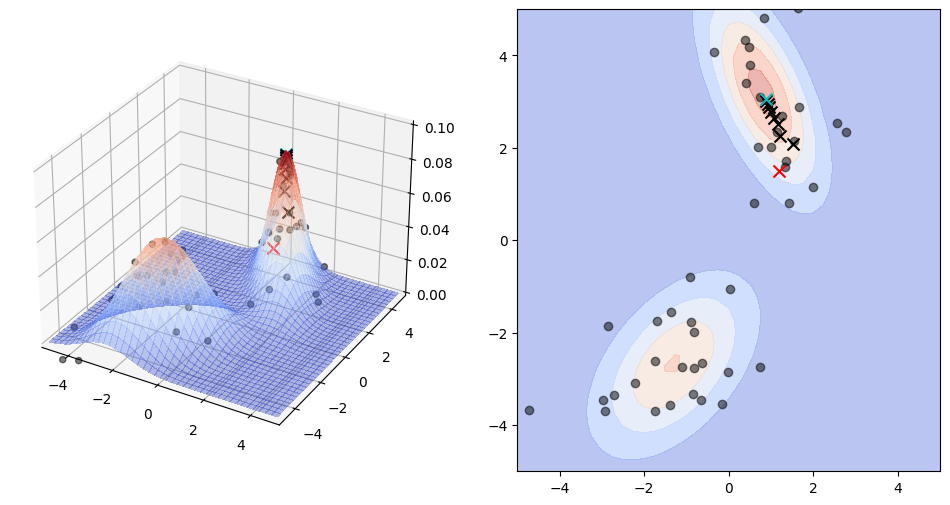

In [10]:
# @title Two Gaussians Score Function (Run Cell)
from matplotlib import cm

x0 = 1.2  # @param {type:"slider", min:-5, max:5, step:0.1}
x1 = 1.5  # @param {type:"slider", min:-5, max:5, step:0.1}
x = jnp.array([x0, x1], dtype=jnp.float32)

T = 9  # @param {type:"slider", min:1, max:10, step:1}
λ = 0.55  # @param {type:"slider", min:0.1, max:1, step:0.05}


# Make plots of the density p(x)
X0 = jnp.arange(-5, 5.1, 0.25)
X1 = jnp.arange(-5, 5.1, 0.25)
X0, X1 = jnp.meshgrid(X0, X1)

Xs = jnp.concatenate([X0.reshape(-1, 1), X1.reshape(-1, 1)], axis=1)
Z = jax.vmap(density_fn)(Xs).reshape(X1.shape)


fig = plt.figure(figsize=(12, 6))

ax1 = fig.add_subplot(121, projection="3d")
ax1.plot_surface(X0, X1, Z, cmap=cm.coolwarm, linewidth=0, alpha=0.4, antialiased=False)

ax2 = fig.add_subplot(122)
ax2.contourf(X0, X1, Z, cmap=cm.coolwarm, alpha=0.4, antialiased=False)


# Plot some samples from the true data distribution
key1, key2 = jax.random.split(jax.random.PRNGKey(42))
samples1, log_probs1 = dist_1.sample_and_log_prob(seed=key1, sample_shape=(25))
samples2, log_probs2 = dist_2.sample_and_log_prob(seed=key2, sample_shape=(25))

log_probs = jnp.concatenate([log_probs1, log_probs2])
probs = 0.5 * jnp.exp(log_probs)
samples = jnp.concatenate([samples1, samples2])

ax1.scatter(samples[:, 0], samples[:, 1], probs, c="k", marker="o", alpha=0.5)
ax2.scatter(samples[:, 0], samples[:, 1], c="k", marker="o", alpha=0.5)


# Plot the trajectory of the sample over time
ax1.scatter(x[0], x[1], density_fn(x), c="r", marker="x", s=75)
ax2.scatter(x[0], x[1], c="r", marker="x", s=75)

for t in range(T):
    x = x + λ * score_fn(x)

    color = "k" if t < T - 1 else "c"
    ax1.scatter(x[0], x[1], density_fn(x), c=color, marker="x", s=75)
    ax2.scatter(x[0], x[1], c=color, marker="x", s=75)


ax1.set_ylim(-5, 5)
ax1.set_xlim(-5, 5)
ax1.set_zlim(0, 0.1)

ax2.set_ylim(-5, 5)
ax2.set_xlim(-5, 5)

plt.show()

# **Diffusion**

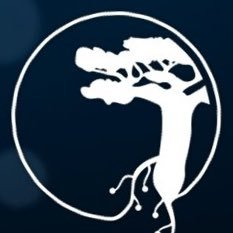

In [11]:
# @title Get DLI logo (Run Cell)
url = "https://pbs.twimg.com/profile_images/1271511794650144770/oS8XqsX-_400x400.jpg"
image = Image.open(requests.get(url, stream=True).raw)
image

In [12]:
def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return jnp.linspace(beta_start, beta_end, timesteps)


In [13]:
TIMESTEPS = 200

# Define beta schedule.
betas = linear_beta_schedule(timesteps=TIMESTEPS)


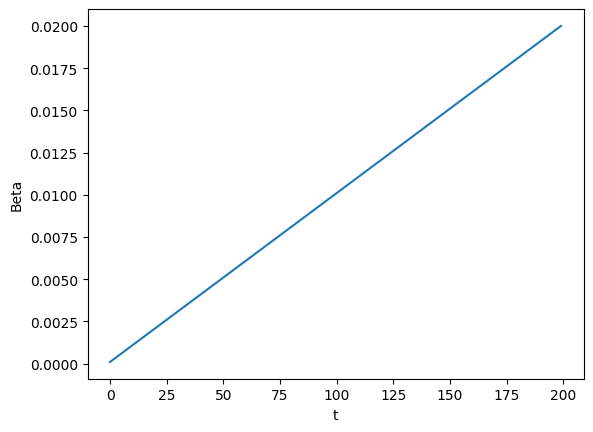

In [14]:
plt.plot(betas)
plt.ylabel("Beta")
plt.xlabel("t")
plt.show()

In [15]:
# Define alphas.
alphas = 1.0 - betas
alphas_cumprod = jnp.cumprod(alphas, axis=0)
sqrt_alphas_cumprod = jnp.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = jnp.sqrt(1.0 - alphas_cumprod)

In [16]:
# Forward diffusion - q(x_t|x_0):
def q_sample(x_start, t, noise):
    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise


In [17]:
# Helper function to convert an image into an array of the correct form
# and then apply the run forward diffusion.
def get_noisy_image(image, t, key):
    x_start = jnp.asarray(image, dtype=jnp.float32)[jnp.newaxis, ...]
    x_start = x_start / 255.0  # normalize the images to [0, 1]
    x_start = (x_start * 2.0) - 1.0  # convert range to [-1, 1]

    # add noise
    noise = jax.random.normal(key, x_start.shape)
    x_noisy = q_sample(x_start, t, noise)

    # turn back into image format
    x_noisy = (x_noisy + 1.0) / 2.0
    x_noisy = x_noisy * 255.0
    noisy_image = np.array(x_noisy).astype(jnp.uint8)[0]

    return noisy_image


In [18]:
ts = [2, 9, 29, 99, 199]
imgs = [image] + [
    get_noisy_image(image, jnp.array([t]), jax.random.PRNGKey(0)) for t in ts
]

num_cols = len(imgs)
fig, axs = plt.subplots(figsize=(200, 200), nrows=1, ncols=num_cols, squeeze=False)
for idx, img in enumerate(imgs):
    ax = axs[0, idx]
    ax.imshow(img)
    t = 0 if idx == 0 else ts[idx - 1] + 1

plt.tight_layout()

# **Putting the pieces together**
# Training a Diffusion Model

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


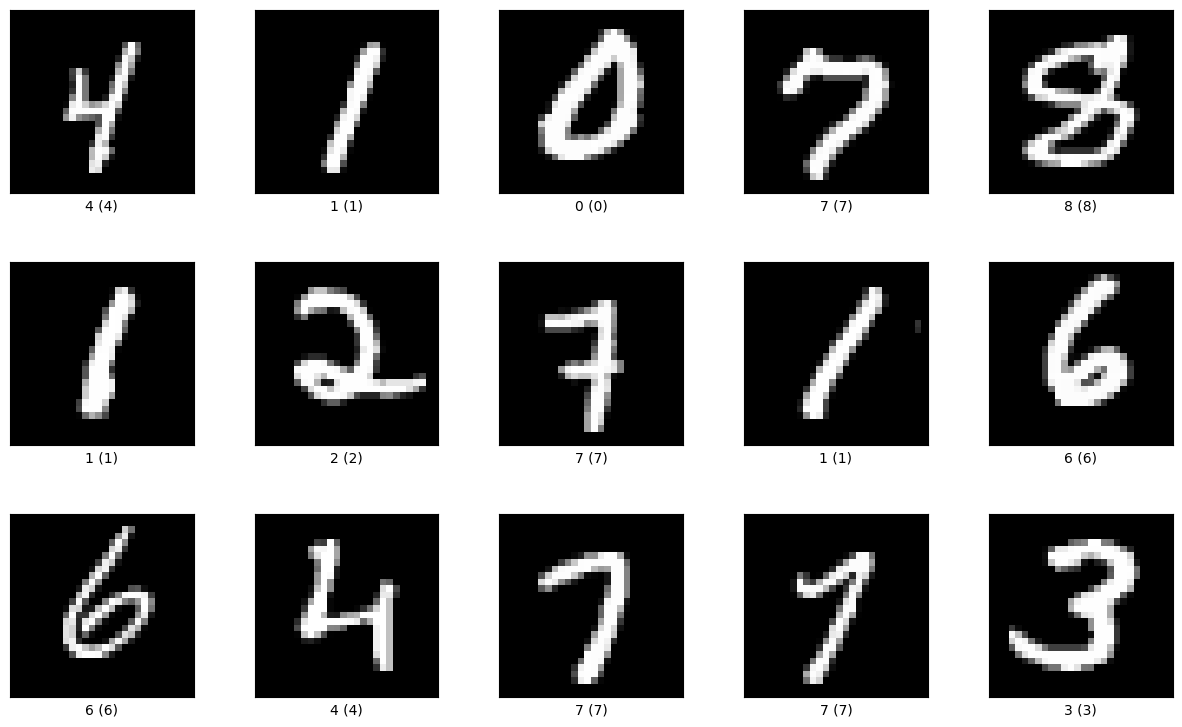

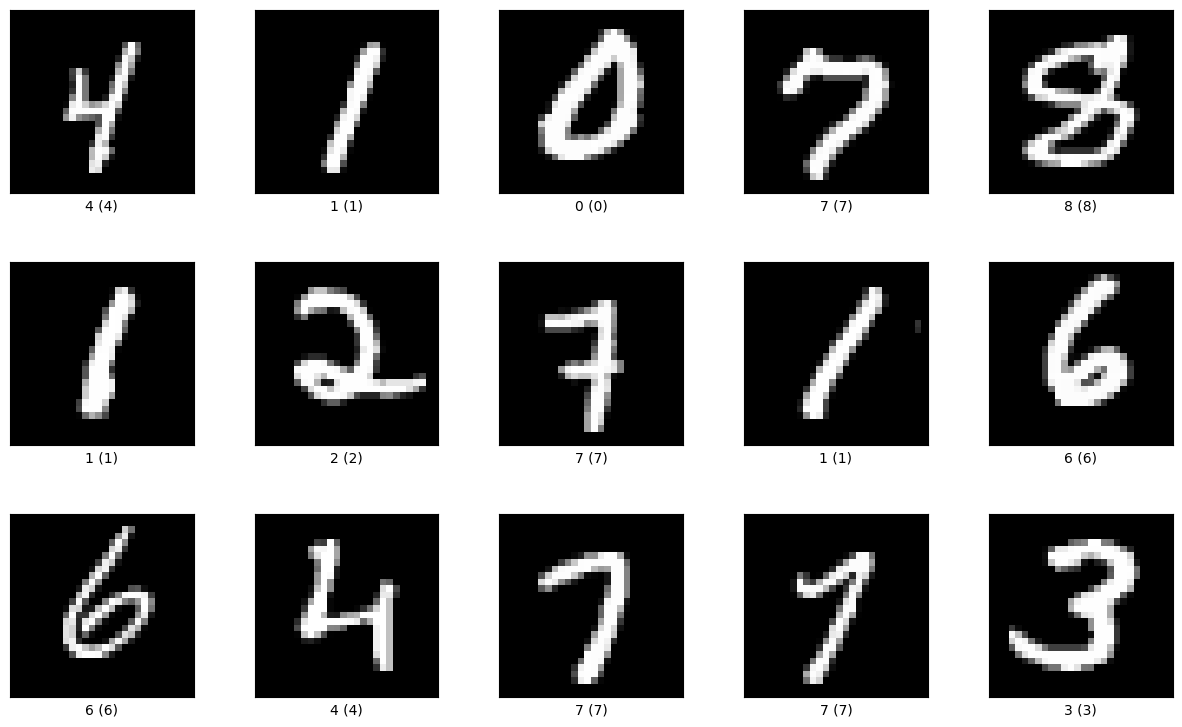

In [19]:
mnist, info = tfds.load("mnist", split="train", with_info=True)
tfds.show_examples(mnist, info, cols=5)

In [20]:
BATCH_SIZE = 128
train_dataset = mnist.shuffle(10 * BATCH_SIZE, seed=0).cache().repeat()
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.map(lambda x: x["image"])
train_dataset = train_dataset.map(lambda x: tf.cast(x, tf.float32))
train_dataset = train_dataset.map(lambda x: (x - 127.5) / 127.5)
train_dataset = iter(tfds.as_numpy(train_dataset))

**Building the NN**

In [21]:
class TimeEmbedding(hk.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def __call__(self, time):
        half_dim = self.dim // 2
        embeddings = jnp.log(10000) / (half_dim - 1)
        embeddings = jnp.exp(jnp.arange(half_dim) * -embeddings)
        embeddings = time[:, jnp.newaxis] * embeddings[jnp.newaxis, :]
        embeddings = jnp.concatenate(
            (jnp.sin(embeddings), jnp.cos(embeddings)), axis=-1
        )
        return embeddings

In [22]:
class Block(hk.Module):
    def __init__(self, dim_out, groups=8):
        super().__init__()
        self.proj = hk.Conv2D(dim_out, kernel_shape=3, padding=(1, 1))
        self.norm = hk.GroupNorm(groups)
        self.act = jax.nn.silu

    def __call__(self, x):
        x = self.proj(x)
        x = self.norm(x)
        x = self.act(x)
        return x


class ResnetBlock(hk.Module):
    """https://arxiv.org/abs/1512.03385"""

    def __init__(self, dim_out, groups=8, change_dim=False):
        super().__init__()
        self.mlp = hk.Sequential([jax.nn.silu, hk.Linear(dim_out)])
        self.block1 = Block(dim_out, groups=groups)
        self.block2 = Block(dim_out, groups=groups)
        self.res_conv = (
            hk.Conv2D(dim_out, kernel_shape=1, padding=(0, 0))
            if change_dim
            else lambda x: x
        )

    def __call__(self, x, time_emb):
        h = self.block1(x)

        time_emb = self.mlp(time_emb)
        # We add new axes to the time embedding to for broadcasting.
        h = time_emb[:, jnp.newaxis, jnp.newaxis] + h

        h = self.block2(h)
        return h + self.res_conv(x)

In [23]:
def SpatialUpsample(dim):
    return hk.Conv2DTranspose(dim, kernel_shape=4, stride=2)


def SpatialDownsample(dim):
    return hk.Conv2D(dim, kernel_shape=4, stride=2, padding=(1, 1))


In [24]:
class Unet(hk.Module):
    def __init__(
        self,
        dim,
        dim_mults=(
            1,
            2,
            4,
        ),
        channels=3,
        resnet_block_groups=7,
    ):
        super().__init__()

        # determine dimensions
        init_dim = dim // 3 * 2
        self.init_conv = hk.Conv2D(init_dim, kernel_shape=7, padding=(3, 3))

        # time embeddings
        time_dim = dim * 4
        self.time_mlp = hk.Sequential(
            [
                TimeEmbedding(dim),
                hk.Linear(time_dim),
                jax.nn.gelu,
                hk.Linear(time_dim),
            ]
        )

        # layers
        self.downs = []
        dims = list(map(lambda m: dim * m, dim_mults))

        for ind, stage_dim in enumerate(dims):
            is_last = ind >= len(dims) - 1

            self.downs.append(
                [
                    ResnetBlock(stage_dim, groups=resnet_block_groups, change_dim=True),
                    ResnetBlock(stage_dim, groups=resnet_block_groups),
                    # We don't apply spatial downsampling to the last stage. This is
                    # because we go from 28x28 -> 14x14 -> 7x7 in the 1st and 2nd
                    # stages and 7 can't be halved without a remainder, which
                    # would cause problems in the upsampling path.
                    SpatialDownsample(stage_dim) if not is_last else lambda x: x,
                ]
            )

        mid_dim = dims[-1]
        self.mid_block1 = ResnetBlock(mid_dim, groups=resnet_block_groups)
        self.mid_block2 = ResnetBlock(mid_dim, groups=resnet_block_groups)

        self.ups = []
        rev_dims = list(reversed(dims))
        for ind, stage_dim in enumerate(rev_dims):
            is_last = ind >= len(rev_dims) - 1

            self.ups.append(
                [
                    ResnetBlock(stage_dim, groups=resnet_block_groups, change_dim=True),
                    ResnetBlock(stage_dim, groups=resnet_block_groups),
                    SpatialUpsample(stage_dim) if not is_last else lambda x: x,
                ]
            )

        self.final_block = ResnetBlock(dim, groups=resnet_block_groups)
        self.final_conv = hk.Conv2D(channels, kernel_shape=1, padding=(0, 0))

    def __call__(self, x, time):
        x = self.init_conv(x)
        t = self.time_mlp(time)

        h = []
        # downsample
        for block1, block2, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            h.append(x)
            x = downsample(x)

        # bottleneck
        x = self.mid_block1(x, t)
        x = self.mid_block2(x, t)

        # upsample
        for block1, block2, upsample in self.ups:
            x = jnp.concatenate((x, h.pop()), axis=-1)
            x = block1(x, t)
            x = block2(x, t)
            x = upsample(x)

        x = self.final_block(x, t)
        return self.final_conv(x)


Training

Setup

In [25]:
LR = 3e-4
IMAGE_SIZE = 28
CHANNELS = 1


In [26]:
def build_forward_fn(dim, channels):
    def forward_fn(x, t):
        """Forward pass."""
        model = Unet(dim, channels=channels)

        return model(x, t)

    return forward_fn


forward_fn = build_forward_fn(dim=IMAGE_SIZE, channels=CHANNELS)
# Convert from a stateful to a stateless forward function.
forward_fn = hk.transform(forward_fn)
# Remove unnecessary random seed from the forward function.
forward_fn = hk.without_apply_rng(forward_fn)

In [27]:

# Initialise model.
init_rng = jax.random.PRNGKey(42)
dummy_input = jnp.ones((1, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
params = forward_fn.init(init_rng, dummy_input, jnp.array([0]))

# Set up the optimiser.
optimiser = optax.adam(LR)
opt_state = optimiser.init(params)

**The Loss Function**

In [29]:
@jax.jit
def loss_fn(params, x_0, t, ϵ):
    # Sample x_t from the forward diffusion process - q(x_t|x_0):
    x_t = q_sample(x_start=x_batch, t=t, noise=ϵ)

    # Predict ϵ using our U-Net with inputs x_t and t:
    predicted_ϵ = forward_fn.apply(params, x_t, t)

    # Calculate the loss as the mean squared error between the true and predicted ϵs:
    loss = jnp.mean((ϵ - predicted_ϵ) ** 2)

    return loss

In [30]:
@jax.jit
def update(params, opt_state, batch, t, noise):
    loss, grads = jax.value_and_grad(loss_fn)(params, batch, t, noise)
    updates, opt_state = optimiser.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss


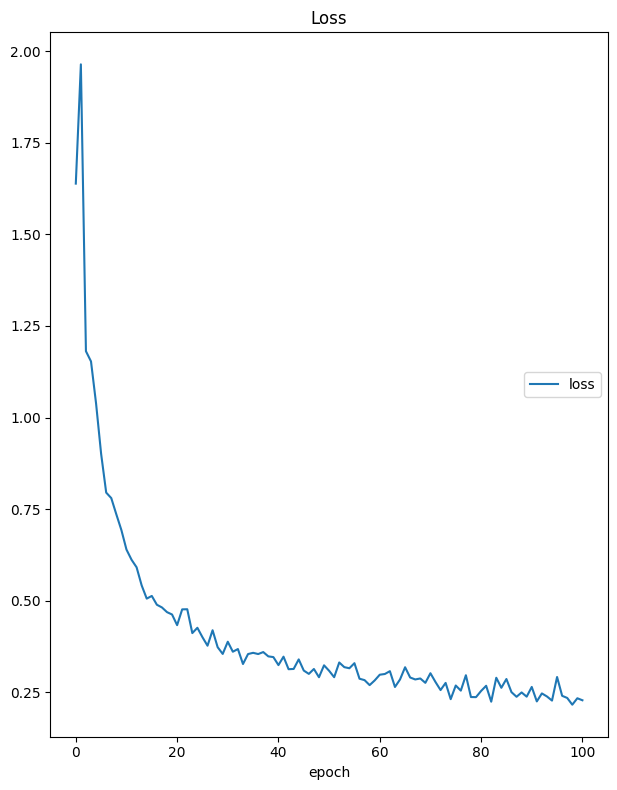

Loss
	loss             	 (min:    0.216, max:    1.964, cur:    0.228)


In [ ]:
%%time
plotlosses = PlotLosses()

MAX_STEPS = 2501
key = jax.random.PRNGKey(42)

best_loss = jnp.inf
for step in range(MAX_STEPS):
    key, noise_key, time_key, sample_key = jax.random.split(key, num=4)

    x_batch = next(train_dataset)
    batch_size = x_batch.shape[0]

    t = jax.random.randint(time_key, (batch_size,), 0, TIMESTEPS)
    noise = jax.random.normal(noise_key, x_batch.shape)
    params, opt_state, loss = update(params, opt_state, x_batch, t, noise)

    if loss < best_loss:
        best_params = params
        best_loss = loss

    plotlosses.update({"loss": loss})
    if step % 50 == 0:
        plotlosses.send()

# **Sampling**

In [ ]:
sqrt_recip_alphas = jnp.sqrt(1.0 / alphas)

alphas_cumprod_prev = jnp.concatenate((jnp.array([1.0]), alphas_cumprod[:-1]))
posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)


# Algorithm 2 line 4:
@partial(jax.jit, static_argnums=4)
def sample_iteration(params, key, x, t, add_noise=True):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * forward_fn.apply(params, x, t) / sqrt_one_minus_alphas_cumprod_t
    )

    posterior_variance_t = extract(posterior_variance, t, x.shape)
    noise = jax.random.normal(key, x.shape)

    return model_mean + jnp.sqrt(posterior_variance_t) * noise


# Algorithm 2
def sample(params, key, image_size, batch_size=16, channels=3):
    shape = (batch_size, image_size, image_size, channels)

    img_key, key = jax.random.split(key, num=2)
    # start from pure noise (for each example in the batch)
    img = jax.random.normal(img_key, shape)
    imgs = []

    for i in tqdm(
        reversed(range(0, TIMESTEPS)), desc="sampling loop time step", total=TIMESTEPS
    ):
        noise_key, key = jax.random.split(key, num=2)
        img = sample_iteration(
            params, noise_key, img, jnp.full((batch_size,), i), i != 0
        )
        imgs.append(img)

    return imgs


In [ ]:
samples = sample(best_params, key, IMAGE_SIZE, 25, CHANNELS)


In [ ]:
# @title Show samples (Run Cell)
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    img_index = np.random.randint(0, 50000)
    plt.imshow(samples[-1][i][:, :, 0])

In [ ]:
sample_index = 13  # @param

fig = plt.figure()
ims = []
for i in range(TIMESTEPS):
    im = plt.imshow(samples[i][sample_index][:, :, 0], animated=True)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    ims.append([im])

animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=5000)
plt.close()

HTML(animate.to_html5_video())

# **Guided diffusion**